In [275]:
%matplotlib inline

import os
import sys
from datetime import datetime

# image hash dependencies
from PIL import Image
import imagehash

import numpy as np
from scipy.spatial.distance import hamming
from jellyfish import jaro_distance
import scipy.cluster.hierarchy as scipycluster

import matplotlib.pyplot as plt

basePath="/Users/david/src/python/StabiHacks/sbbget/sbbget_downloads.leske_mini/download_temp/"
#basePath="/Users/david/src/python/StabiHacks/sbbget/sbbget_downloads.leske/download_temp/"

In [276]:
def printLog(text):
    now = str(datetime.now())
    print("[" + now + "]\t" + text)
    # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print
    sys.stdout.flush()

In [277]:
# check all subdirectories startings with PPN as each PPN stands for a different medium
dirsPerPPN = dict()
ppnDirs=[]
for x in os.listdir(basePath):
    if x.startswith("PPN"):
        dirsPerPPN[x]=[]
        ppnDirs.append(x)

In [301]:
# browse all directories below sbbGetBasePath and search for *_FULLTEXT and *_TIFF directories
# and associate each with its PPN

# each dictionary will use a PPN as key and an array of file paths (or the like) as value
fulltextFilePaths = dict()
jpgFilePaths = dict()
jpgHashes=dict()

printLog("Analysing directories and calculating image hashes...")
for ppn in ppnDirs:
    fulltextFilePaths[ppn] = []
    jpgFilePaths[ppn] = []
    jpgHashes[ppn]=[]
    for dirpath, dirnames, files in os.walk(basePath+ppn):
        for name in files:
            if dirpath.endswith("_FULLTEXT"):
                # if we found a fulltext directory, only add XML files, i.e., the ALTO candidate files
                if name.endswith(".xml") or name.endswith(".XML"):
                    fulltextFilePaths[ppn].append(os.path.join(dirpath, name))
                    dirsPerPPN[ppn].append(os.path.join(dirpath, name))
            if dirpath.endswith("_TIFF"):
                # if we found a image directory, only add JPEG files,
                if name.endswith(".jpg") or name.endswith(".JPG"):
                    tokens=dirpath.split("FILE_")
                    physicalID=tokens[1].replace("_TIFF","")
                    jpgFilePaths[ppn].append((os.path.join(dirpath, name),physicalID))
                    hash=imagehash.phash(Image.open(os.path.join(dirpath, name)))
                    jpgHashes[ppn].append(hash)
printLog("Done.")                

[2021-03-12 14:13:27.642562]	Analysing directories and calculating image hashes...
[2021-03-12 14:13:29.809212]	Done.


In [302]:
totalPages=0
for ppn in dirsPerPPN:
    l=len(dirsPerPPN[ppn])
    l_fulltext=len(fulltextFilePaths[ppn])
    print("%s with %i pages and %i fulltext files."%(ppn,l,l_fulltext))
    totalPages+=l
print("Total pages: %i"%totalPages)

PPN745219993 with 62 pages and 10 fulltext files.
PPN745232752 with 60 pages and 10 fulltext files.
PPN745236499 with 60 pages and 10 fulltext files.
Total pages: 182


In [313]:
words=[]
ppns=[]
ppn_jpg=[]
for ppn in jpgHashes:
    for i,hash_val in enumerate(jpgHashes[ppn]):
        ppns.append(ppn)
        words.append((hash_val))
        ppn_jpg.append(jpgFilePaths[ppn][i][0])

# Upper triangle of an array
r=np.triu_indices(n=len(words), k=1)


def d_demo(coord):
    #print(coord)
    i, j = coord
    return (words[i]-words[j])

In [314]:
np.set_printoptions(precision=4)

printLog("Calculating distance matrix...")
# axis (3rd parameter): 0= along y axis, 1= along x axis
r2=np.apply_along_axis(d_demo, 0, r)
printLog("Done.")

[2021-03-12 14:14:39.424447]	Calculating distance matrix...
[2021-03-12 14:14:39.434956]	Done.


In [315]:
r2

array([36, 32, 36, 20, 42, 12, 22, 42, 42, 26, 36, 34, 30, 24, 32, 30, 32,
       36, 34, 24, 32, 30, 32, 24, 34, 28, 30, 30, 34, 20, 22, 32, 14, 36,
       34, 34, 12, 34, 26, 18, 24, 34, 20, 38, 32, 22, 22, 38, 22, 20, 22,
       38, 22, 34, 32, 20, 20, 22, 32, 24, 28, 30, 26, 20, 32, 26, 22, 22,
       36, 20, 38, 38, 22, 24, 32, 20, 16, 28, 36, 28, 32, 32, 22, 18, 38,
       20, 32, 28, 32, 18, 30, 18, 22, 14, 38, 24, 34, 34, 22, 18, 30, 30,
       24, 20, 30, 28, 30, 28, 22, 28, 38, 16, 18, 40, 32, 14, 36, 32, 24,
       20, 34, 14, 22, 34, 38, 24, 34, 34, 26, 18, 32, 20, 16, 34, 32, 40,
       32, 36, 14, 34, 26, 20, 24, 28, 16, 34, 32, 16, 12, 36, 16, 22, 20,
       38, 14, 36, 28, 22, 16, 14, 44, 40, 22, 36, 30, 26, 24, 32, 24, 30,
       34, 32, 26, 32, 28, 30, 24, 36, 22, 22, 30, 30, 46, 34, 24, 32, 36,
       28, 18, 36, 24, 26, 34, 32, 22, 30, 28, 28, 22, 34, 12, 22, 24, 32,
       34, 36, 34, 34, 32, 40, 32, 40, 36, 38, 42, 36, 30, 34, 40, 36, 36,
       40, 38, 34, 32, 28

In [316]:
Z=scipycluster.linkage(r2)
#Z

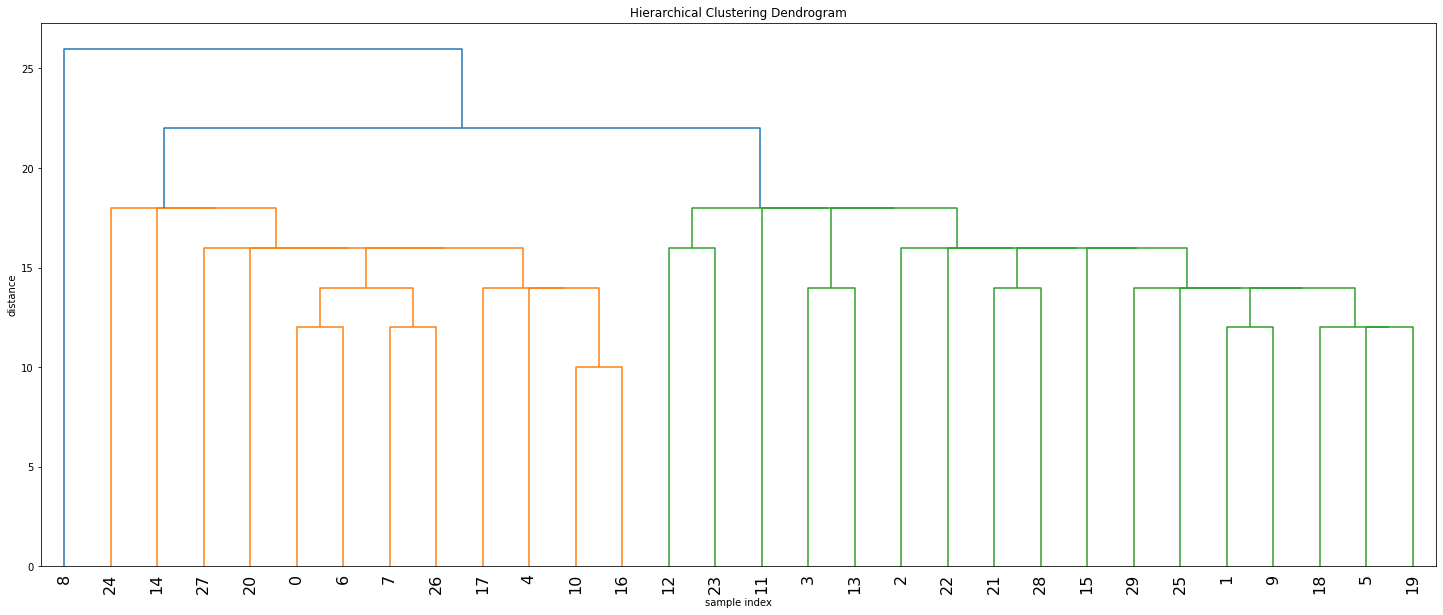

In [317]:
# don't run this plotting function with large distance matrices, it will be unreadable
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
scipycluster.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
)
plt.show()

In [318]:
clusters=scipycluster.fcluster(Z, t=15,criterion="maxclust")
clusters

array([1, 6, 6, 5, 1, 6, 1, 1, 8, 6, 1, 7, 4, 5, 2, 6, 1, 1, 6, 6, 1, 6,
       6, 4, 3, 6, 1, 1, 6, 6], dtype=int32)

In [319]:
h_1=str(jpgHashes["PPN745219993"][0])
h_1

'd53674ad62ab009f'

In [320]:
# indices of cluster, words and ppn_jpg refer to the same element
cluster_dict=dict()
for i,val in enumerate(clusters):
    if val not in cluster_dict:
        cluster_dict[val]=[]
    cluster_dict[val].append(ppn_jpg[i])

html=""
for cluster in cluster_dict:
    #print(cluster)
    html+="<h1>"+str(cluster)+"</h1>\n"
    for v in cluster_dict[cluster]:
        #print("\t"+v)
        html+="<img src='"+v+"' width='200px'/><br />\n"

In [321]:
f = open(basePath+"viz.html", "w")
f.write(html)
f.close()

In [327]:
iframe_references=[]



for ppn in jpgFilePaths:
    # we have to sort the file path by their physical ID before output
    sorted_by_physID = sorted(jpgFilePaths[ppn], key=lambda tup: tup[1])
    html=""
    for v,x in sorted_by_physID:
        html+="<img src='"+v+"' width='150px' alt='"+x+"'/>\n"

    f = open(basePath+"overview_"+ppn+".html", "w")
    f.write(html)
    f.close()
    
    iframe_references.append(basePath+"overview_"+ppn+".html")

html=""
for iframe in iframe_references: 
    html+="<iframe src='"+iframe+"'' width='100%'></iframe> <br />"

f = open(basePath+"comparison.html", "w")
f.write(html)
f.close()

[('/Users/david/src/python/StabiHacks/sbbget/sbbget_downloads.leske_mini/download_temp/PPN745219993/FILE_0001_TIFF/PPN745219993.jpg', '0001'), ('/Users/david/src/python/StabiHacks/sbbget/sbbget_downloads.leske_mini/download_temp/PPN745219993/FILE_0002_TIFF/PPN745219993.jpg', '0002'), ('/Users/david/src/python/StabiHacks/sbbget/sbbget_downloads.leske_mini/download_temp/PPN745219993/FILE_0003_TIFF/PPN745219993.jpg', '0003'), ('/Users/david/src/python/StabiHacks/sbbget/sbbget_downloads.leske_mini/download_temp/PPN745219993/FILE_0004_TIFF/PPN745219993.jpg', '0004'), ('/Users/david/src/python/StabiHacks/sbbget/sbbget_downloads.leske_mini/download_temp/PPN745219993/FILE_0005_TIFF/PPN745219993.jpg', '0005'), ('/Users/david/src/python/StabiHacks/sbbget/sbbget_downloads.leske_mini/download_temp/PPN745219993/FILE_0006_TIFF/PPN745219993.jpg', '0006'), ('/Users/david/src/python/StabiHacks/sbbget/sbbget_downloads.leske_mini/download_temp/PPN745219993/FILE_0007_TIFF/PPN745219993.jpg', '0007'), ('/Us

https://pypi.org/project/ImageHash/

https://stackoverflow.com/questions/998662/what-is-image-hashing-used-for (erklärt die Verfahren)

M.Sc. thesis zum p-hash http://www.phash.org/docs/pubs/thesis_zauner.pdf

noch mehr zu den Distanzen:

https://tech.okcupid.com/evaluating-perceptual-image-hashes-okcupid/
https://content-blockchain.org/research/testing-different-image-hash-functions/
